# Food Detection using YOLOv3-Tiny

## Training YOLOv3-Tiny

Training the YOLOv3-Tiny is done using google colab. The steps can be seen in ``1 Training YOLOv3-Tiny_Food Detection`` notebook.  
After training, the modified config ``.cfg`` file, trained YOLOv3-Tiny weights and the ``obj`` files are downloaded.

## Predicting / Detection

In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set the location of the weights and config file
yolo_files = "yolo files/"
config_file = yolo_files + "yolov3tiny_custom.cfg"
weights_file = yolo_files + "yolov3tiny_custom_last.weights"

# open labels' name
labels_file = yolo_files + "obj.names"
labels = open(labels_file).read().strip().split("\n")

# set bounding box colors
#np.random.seed(42)
#colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

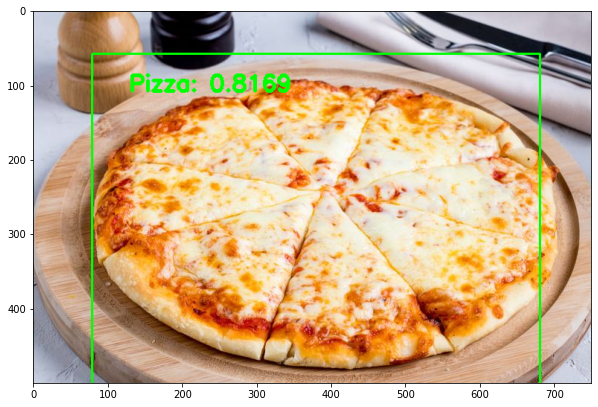

In [3]:
# open test image
images = glob.glob("test images/*[jpg|png|jpeg]")
image = images[5]

image = cv2.imread(image)
(H, W) = image.shape[:2]

# set the YOLOv3-tiny network
net = cv2.dnn.readNetFromDarknet(config_file, weights_file)

# input the test image to the network
blob = cv2.dnn.blobFromImage(image, 1 / 255., (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# run prediction
ln = net.getLayerNames()
ln =[ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
outputs = net.forward(ln)

# set confidence limit and threshold value
confidence_limit = 0.3
nms_threshold = 0.3

boxes = []
confidences = []
class_ids = []

# save all bounding box, confidence and class id values if the confidence value > confidence limit
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > confidence_limit:
            box = detection[:4] * np.array([W, H, W, H])
            (center_x, center_y, width, height) = box.astype("int")
            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)
indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_limit, nms_threshold)
if len(indices) > 0:
    for j in indices.flatten():
        (x, y) = (boxes[j][0], boxes[j][1])
        (w, h) = (boxes[j][2], boxes[j][3])

        color = [int(c) for c in colors[class_ids[j]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(labels[class_ids[j]], confidences[j])
        cv2.putText(image, text, (x + 50, y + 50), cv2.FONT_HERSHEY_SIMPLEX,
                   1, color, 4)

plt.figure(figsize=(10, 10))      
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

**Result**  
1. The YOLOv3-based object detector is able to detect pizza, hamburger and hotdog to a certain degree (it's not perfect).  
- The confidence value of detected object can be so low (0.39), whereas at some objects, the confidence value can reach 0,81
- When the objects (food) are close, the object detector fails to detect all the food  

2. The imperfection of the detector may because we use the tiny version of the YOLOv3 network (the tiny version of YOLO network has shallower network layers).  
Furthermore, it is one known drawback of YOLO network to have difficulties detecting objects grouped closely, such as the detection in second and fifth image.

3. There are still many areas available to improve the detector:
- use the standard YOLOv3 network (but takes longer time to train)
- increase the number of training images